## Lotka Volterra Equations

This notebook is a demonstration of the usage of SymPy to model dynamical systems. 



In [4]:
import warnings
import numpy as np
import pandas as pandas
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import seaborn as sns
import sympy
sympy.init_printing(use_unicode=True)
from ipywidgets import interact

%matplotlib inline

# Notebook settings:

rc = {'line.linewidth': 2,
      'axes.labelsize': 18, 
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}

sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

## Model setup

The LV model is a system of two differential equations, given by:

$$ \frac{dN_1}{dt} = r_1 N_1 (\frac{K_1 - N_1 - \alpha N_2}{K_1}), $$

$$ \frac{dN_2}{dt} = r_2 N_2 (\frac{K_2 - N_2 - \beta N_1}{K_2}). $$

$N_i$ is the population size of species $i$, 
$t$ is time, 
$r_i$ is the growth rate of species $i$,
$K_i$ is the environment's carrying capacity, 
and $\alpha, \beta$ are inter-species interaction parameters. If species 1 is the prey, then $\alpha$ is positive, since an increase in the population of *2* reduces the population of *1*. Conversely, $\beta$ must be positive for predator species 2. 



In [5]:
# Using SymPy
# define two sets of variables for the two equations of motion.
# in sympy, we need to declare the variables first.
# each variable on the LHS is attached to a symbol from the set sympy.symbols. 

# Prey:
r1, K1, N1, alpha = sympy.symbols('r_1 K_1 N_1 alpha')

# Predator
r2, K2, N2, beta = sympy.symbols('r_2 K_2 N_2 beta')

# Then, we define the equations of motion

# Prey population dynamics:

dN1_dt = r1 * N1 * (K1 - N1 - alpha * N2) / K1
dN2_dt = r2 * N2 * (K2 - N2 - beta * N1) / K2

# Display equation system

dN1_dt, dN2_dt


$\displaystyle \left( \frac{N_{1} r_{1} \left(K_{1} - N_{1} - N_{2} \alpha\right)}{K_{1}}, \ \frac{N_{2} r_{2} \left(K_{2} - N_{1} \beta - N_{2}\right)}{K_{2}}\right)$

In [6]:
# Find the steady state of the system of equations

ss_N1 = sympy.Eq(dN1_dt, 0) # sets prey equation equal to zero
ss_N2 = sympy.Eq(dN2_dt, 0) # sets predator equation equal to zero
dN1_dt
dN2_dt

In [7]:
# Use sympy.solve to find analytical solutions for the equations of motion.

ss_N1_sol = sympy.solve(ss_N1, N1) # solve the homogeneous prey equation for N1
ss_N2_sol = sympy.solve(ss_N2, N2) # solve the homogenous predator equation for N2
ss_N1_sol, ss_N2_sol

The steady-state solution to the system of equations is given by:

$\displaystyle \left( \left[ 0, \ K_{1} - N_{2} \alpha\right], \ \left[ 0, \ K_{2} - N_{1} \beta\right]\right)$.

That is; there is a trivial solution where both populations are extinct, and a non-trivial solution with positive population. 




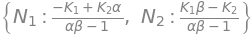

In [8]:
# Re-arrange solutions for populations in equilibrium

ss_eqm = sympy.solve((sympy.Eq(N1, ss_N1_sol[1]), # solves for N1 given the second solution in the solution vector for N1
                      sympy.Eq(N2, ss_N2_sol[1])), (N1, N2))

ss_eqm



$\displaystyle \left\{ N_{1} : \frac{- K_{1} + K_{2} \alpha}{\alpha \beta - 1}, \ N_{2} : \frac{K_{1} \beta - K_{2}}{\alpha \beta - 1}\right\}$

In [9]:
# Use Lambdify to transform the differential equations

dN1_dt_num = sympy.utilities.lambdify([N1, N2, r1, K1, alpha], dN1_dt)
dN2_dt_num = sympy.utilities.lambdify([N2, N1, r2, K2, beta], dN2_dt)

def lotka_voltera_rhs(n1_n2, t, *p):
    n1, n2 = n1_n2
    r_1, k1, a, r_2, k2, b = p

    n1dot = dN1_dt_num(n1, n2, r_1, k1, a)
    n2dot = dN2_dt_num(n2, n1, r_2, k2, b)

    return np.array([n1dot, n2dot])

In [10]:
# set parameter values

r_1, r_2 = [0.5, 0.2]
k1, k2 = [100, 50]
a, b = [1.2, 0.2]
args = (r_1, k1, a, r_2, k2, b)

#Initial population size
n1_n2_0 = [2,2]

#Time points under consideration
t = np.linspace(0, 100, 1000) # start, stop, number

# solve using odeint
n1_n2 = odeint(lotka_voltera_rhs, n1_n2_0, t, args=args)


Text(0, 0.5, 'Population size')

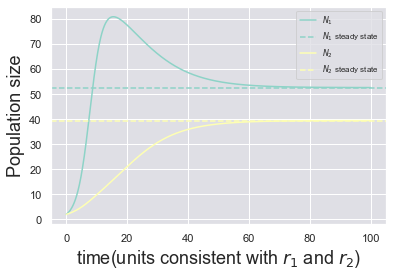

In [24]:
# Plot the numeric solution, including the null clines obtained previously as dashed lines

for i, N in enumerate([N1, N2]):
    plt.plot(t, n1_n2[:, i], label = r'${0:s}$'.format(sympy.latex(N)))
    plt.axhline(y = ss_eqm[N].subs({K1: k1, K2: k2, alpha: a, beta: b}),
                linestyle = '--', color=sns.color_palette()[i],
                label = r'${0:s}$ steady state'.format(sympy.latex(N)))

plt.legend(loc=1, fontsize=8)
plt.xlabel('time (units consistent with $r_1$ and $r_2$)')
plt.ylabel('Population size')